# Import Dependencies

In [ ]:
# Re-implement using pure shapely + rasterio (no geopandas) to avoid array-interface issues
import os, re, json, warnings
import geopandas as gpd
import pathlib
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow
from rasterstats import zonal_stats
import contextily as cx
warnings.filterwarnings("ignore", category=UserWarning)

In [1]:
import sys
sys.path.append('src')
import well_pump 

# Select Root Folder and OS

In [2]:
raw_fold_drive = "G"

if sys.platform == 'darwin':
    print('mac')
    raw_fold = pathlib.Path('/users/ink/Google Drive/My Drive/WORK/Milford/')
else:
    print('pc')
    raw_fold = pathlib.Path(f'{raw_fold_drive}:/My Drive/WORK/Milford/')
planet_fold = raw_fold / 'Planet'


pc


# Import Polygons

I used modified place of use polygons from the Utah Division of Water Rights GIS layers.  I start by assigning an id, reprojecting to a CRS that matches the NDVI rasters from Planet, and then saving as a new geopackage.

In [3]:
polys = gpd.read_file("pou_oet.shp").to_crs("EPSG:32612")
polys['OBJECTID'] = range(len(polys))
polys.to_file("pou_ids.gpkg")

We can investigate the geopackage to make sure it looks right.  For this POU data, I added a column `WaterSourc` to delineate which fields get groundwater, surface water, or a mix of the two.

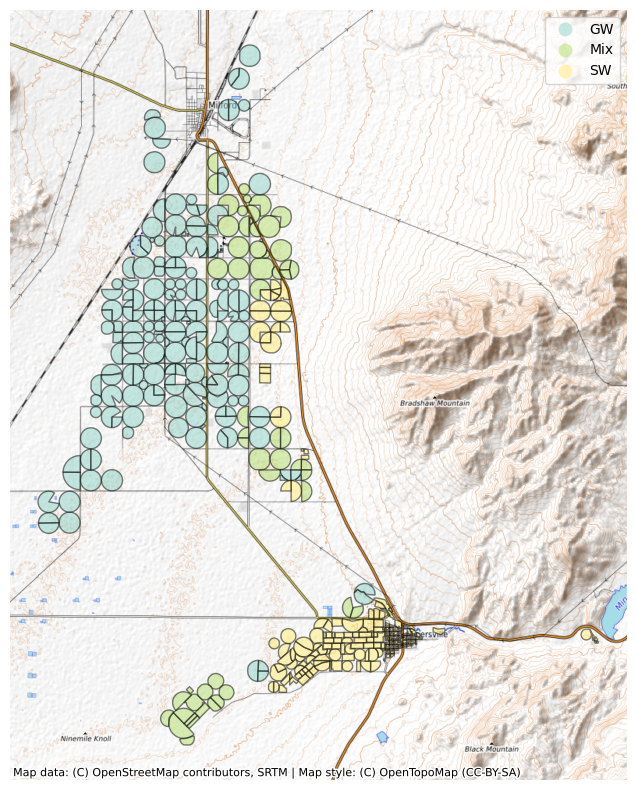

In [4]:
pou = gpd.read_file("pou_ids.gpkg")

#pou.to_file("pou.gpkg")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pou.to_crs(epsg=3857).plot(ax=ax, alpha=0.5, edgecolor='k',
                           column='WaterSourc',
          legend=True,
          cmap='Set3',
          figsize=(10,10)) # Plot your GeoDataFrame
cx.add_basemap(ax, zoom=12, source=cx.providers.OpenTopoMap) # Add the basemap
ax.set_axis_off() # Optional: Hide the axis labels and ticks
plt.show()


# Calculate NDVI from Planet Image Downloads

In [ ]:
for tif in raw_fold.glob("*composite.tif"):
    udm_path = pathlib.Path(str(tif)[:-4] + "_udm2.tif")
    xmls = list(raw_fold.glob("*.xml"))
    for xml in xmls:
        matches = []
        dt = well_pump.parse_date_from_path(tif)
        strdate = f"{dt:%Y%m%d}"
        if strdate in str(xml):
            matches.append(xml)
        xml_path = matches[0] if matches else None
        if xml_path:
            print(strdate)
            xml_path = pathlib.Path(xml_path)
    if udm_path.exists():
        print(tif)
        dt = well_pump.parse_date_from_path(tif)
        ndvi, profile, transform, crs, pixel_size = well_pump.make_ndvi(tif, 
                                                                        xml_path=xml_path, 
                                                                        udm_path=udm_path)
        print(f"NDVI: {ndvi}, Profile: {profile}, Transform: {transform}, CRS: {crs}, Pixel Size: {pixel_size}")
        out_tif = tif.parents[0] / f"{dt:%Y%m%d}_ndvi.tif"
        with rasterio.open(out_tif, 'w', **profile) as dst:
            dst.write(ndvi, 1)


20240809
20240809
20240809
/users/ink/Google Drive/My Drive/WORK/Milford/Planet/2024-08-09_strip_7497591_composite.tif
NDVI: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]], Profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3819, 'height': 6538, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS

## Plot example NDVI

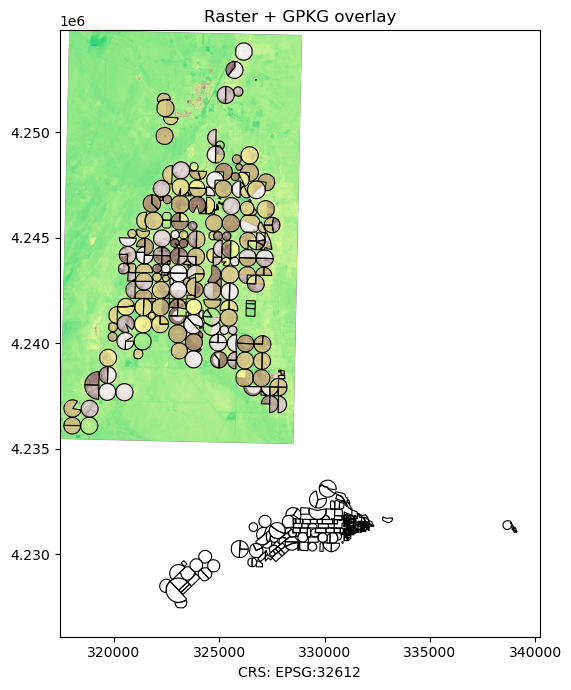

In [ ]:
# Minimal raster + GeoPackage overlay in one cell



# --- paths (edit these) ---
raster_path = raw_fold / "Planet/20240710_ndvi.tif"
gpkg_path   = "pou_ids.gpkg"
gpkg_layer  = None  # or e.g. "parcels"

# --- read raster ---
with rasterio.open(raster_path) as src:
    band = src.read(1, masked=True)       # nodata respected
    r_crs = src.crs
    r_transform = src.transform

# --- read vector ---
gdf = gpd.read_file(gpkg_path, layer=gpkg_layer)

# align CRS (project vector to raster CRS)
if gdf.crs is None:
    gdf = gdf.set_crs(r_crs)
elif gdf.crs != r_crs:
    gdf = gdf.to_crs(r_crs)

# --- plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# raster first
im = rioshow(band, transform=r_transform, ax=ax, cmap="terrain", alpha=0.95)

# vector on top (works for points/lines/polygons)
if not gdf.empty:
    gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.8)

# cosmetics
#cbar = fig.colorbar(im, ax=ax, shrink=0.8, label="Band 1")
ax.set_title("Raster + GPKG overlay")
ax.set_xlabel(f"CRS: {r_crs.to_string() if r_crs else 'unknown'}")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


# Calculate Zonal Stats of NDVI to polygons

Iterate through NDVI rasters, conducting zonal statistics for each one.  Pull date from file name. This process is slow, and takes about 15 minutes to run.

In [7]:
zonal_dfs = {}

for ndvi in planet_fold.glob("*_ndvi.tif"):
    dt =str(ndvi.stem).split("_")[0]
    try:
        ndvi_vals = zonal_stats(polys,
                                    str(ndvi), 
                                    stats="mean")
        ndvis = [v['mean'] for v in ndvi_vals]
        zonal_dfs[dt] = ndvis
    except Exception as e:
        print(f"Error processing {ndvi.stem}: {e}")
        pass
ndvi_df = pd.DataFrame.from_dict(zonal_dfs, orient="columns")


Combine zonal statistics output into one dataframe and reshape to a nice timeseries

In [8]:
pl = polys['OBJECTID'].to_dict()
ndvi_df['OBJECTID'] = ndvi_df.index.map(pl)
ndvi_df = ndvi_df.set_index('OBJECTID')
ndvi_df = ndvi_df.stack().rename("ndvi").reset_index().rename(columns={'level_1':'date'})
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df = ndvi_df.set_index(['OBJECTID', 'date']).sort_index()

ndvi_df.to_csv("pou_ndvi_timeseries.csv")

# Classify Fields by Timeseries

In [ ]:
# Load the CSV, build functions to classify plot type, and detect alfalfa cut dates.


# ---- Load data ----
path = "pou_ndvi_timeseries.csv"
df = pd.read_csv(path)

# Try to normalize column names and index
# Expect columns like: field_id, date (or timestamp), ndvi
cols = {c.lower().strip(): c for c in df.columns}
# Find likely columns
fid_col = None
date_col = None
ndvi_col = None
for c in df.columns:
    cl = c.lower().strip()
    if fid_col is None and ("field" in cl and "id" in cl):
        fid_col = c
    if date_col is None and (cl in ("date","time","timestamp","datetime") or "date" in cl or "time" in cl):
        date_col = c
    if ndvi_col is None and ("ndvi" in cl):
        ndvi_col = c

# Fallbacks if not found
fid_col = fid_col or df.columns[0]
# Prefer a likely datetime column
if date_col is None:
    # Heuristic: pick the first column that parses as datetime well
    for c in df.columns:
        try:
            pd.to_datetime(df[c])
            date_col = c
            break
        except Exception:
            continue
if ndvi_col is None:
    # try last column
    ndvi_col = df.columns[-1]

# Parse datetime and sort
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values([fid_col, date_col])

# Clean NDVI values (clip to sensible range)
df[ndvi_col] = pd.to_numeric(df[ndvi_col], errors="coerce").clip(lower=0, upper=1)

# Build MultiIndex
df = df.set_index([fid_col, date_col]).sort_index()


# Run classification
results = well_pump.classify_all(df, ndvi_col)

# Save a CSV for download
out_path = "plot_classification_with_cuts.csv"
results.to_csv(out_path)
out_path


'plot_classification_with_cuts.csv'

In [1]:
crp_map = pd.concat([pou,results], axis=1, join="inner")
crp_map['pump_hrs'] = (183 - crp_map['num_cuts']*5)*24
crp_map.to_file("pou_classified.gpkg")
crp_map.plot(column='type', 
                 categorical=True, 
                 legend=True, 
                 figsize=(10,10),
                 cmap='Set3',
                 edgecolor='black',
                 linewidth=0.5)
plt.title("Crop Type Classification Map")

NameError: name 'pd' is not defined

<Axes: title={'center': 'NDVI Time Series for 14, a alfalfa field'}, xlabel='Date', ylabel='NDVI'>

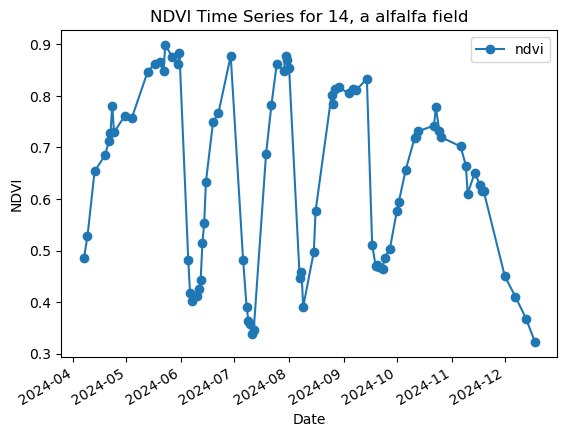

In [ ]:
crp_map = crp_map.set_index(['OBJECTID'])

id = 14
ndvi_df.loc[id].plot(marker='o', 
                       title=f"NDVI Time Series for {id}, {crp_map.loc[id,'type']} field", 
                       ylabel="NDVI", 
                       xlabel="Date")

# Match Field Data to Wells

Prior to importing these wells, I identified the corresponding GROUP NUMBER for each well based on Proof of Beneficial use data and water right information. I also joined the associated field data collected by Kathryn and Greg.

<Axes: >

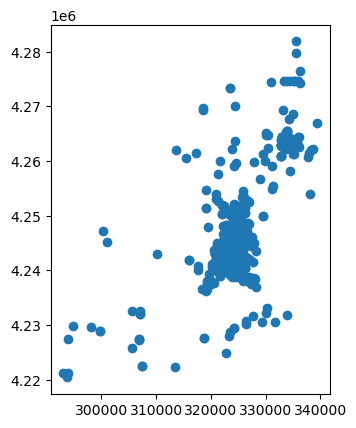

In [15]:
#wells = gpd.read_file("wells_w_efet.gpkg")
wells = gpd.read_file("well_siteid.shp")
wells.plot()

Most agricultural water rights in this area extend from April to October (183 days). Alfalfa cuts typically require about 5 days of drying.

Aggregate the information for each crop.  Group by POU Group Number to join to associated wells.

In [18]:
grp_ndvi = crp_map.groupby(['GROUP_NUMB']).agg({'WaterSourc':'first',
                                     'field_id':'first',
                                     'pump_hrs':'mean',
                                     'peak_ndvi':'max',
                                     'median_ndvi':'median',
                                     'late_med':'min',
                                     'type':'first'
                                     }).round(2).rename(columns={'type':'crp_type'})


In [23]:
wellsndvi = pd.merge(wells,grp_ndvi,left_on='GROUP_NUMB',right_on='GROUP_NUMB')
wellsndvi['X'] = wellsndvi.geometry.x
wellsndvi['Y'] = wellsndvi.geometry.y

wellsndvi.to_file('wells_ndvi.gpkg')
wellsndvi.to_csv('wells_ndvi.csv')